In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [61]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [62]:
raw_dataset = pd.read_csv('housing_price_dataset.csv')

In [63]:
raw_dataset.head()

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
0,2126,4,1,Rural,1969,215355.283618
1,2459,3,2,Rural,1980,195014.221626
2,1860,2,1,Suburb,1970,306891.012076
3,2294,2,1,Urban,1996,206786.787153
4,2130,5,2,Suburb,2001,272436.239065


In [64]:
raw_dataset.describe()

,SquareFeet,Bedrooms,Bathrooms,YearBuilt,Price
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2006.374680,3.498700,1.995420,1985.404420,224827.325151
std,575.513241,1.116326,0.815851,20.719377,76141.842966
min,1000.000000,2.000000,1.000000,1950.000000,-36588.165397
25%,1513.000000,3.000000,1.000000,1967.000000,169955.860225
50%,2007.000000,3.000000,2.000000,1985.000000,225052.141166
75%,2506.000000,4.000000,3.000000,2003.000000,279373.630052
max,2999.000000,5.000000,3.000000,2021.000000,492195.259972


In [65]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SquareFeet    50000 non-null  int64  
 1   Bedrooms      50000 non-null  int64  
 2   Bathrooms     50000 non-null  int64  
 3   Neighborhood  50000 non-null  object 
 4   YearBuilt     50000 non-null  int64  
 5   Price         50000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 2.3+ MB


In [66]:
dataset = raw_dataset.copy()

In [67]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
#train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the examples
test_dataset = dataset.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Price')
test_labels = test_features.pop('Price')

In [68]:
inputs = {
    'SquareFeet':tf.keras.layers.Input(name='SquareFeet', shape=(1,), dtype='int64'),
    'Bedrooms':tf.keras.layers.Input(name='Bedrooms', shape=(1,), dtype='int64'),
    'Bathrooms':tf.keras.layers.Input(name='Bathrooms', shape=(1,), dtype='int64'),
    'YearBuilt':tf.keras.layers.Input(name='YearBuilt', shape=(1,), dtype='int64'),
}

square_feet = tf.keras.layers.Normalization(name='normalization_square_feet', axis=None)
square_feet.adapt(np.array(train_dataset['SquareFeet']))
square_feet = square_feet(inputs.get('SquareFeet'))

bedrooms = tf.keras.layers.Normalization(name='normalization_bedrooms', axis=None)
bedrooms.adapt(np.array(train_dataset['Bedrooms']))
bedrooms = bedrooms(inputs.get('Bedrooms'))

bathrooms = tf.keras.layers.Normalization(name='normalization_bathrooms', axis=None)
bathrooms.adapt(np.array(train_dataset['Bathrooms']))
bathrooms = bathrooms(inputs.get('Bathrooms'))

year_built = tf.keras.layers.Normalization(name='normalization_year_built', axis=None)
year_built.adapt(np.array(train_dataset['YearBuilt']))
year_built = year_built(inputs.get('YearBuilt'))

preprocessing_layers = tf.keras.layers.Concatenate()(
    [square_feet, bedrooms, bathrooms, year_built])

print("Preprocessing layers defined.")

Preprocessing layers defined.


In [69]:
def plot_the_loss_curve(epochs, mse_training, mse_validation):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse_training, label="Training Loss")
  plt.plot(epochs, mse_validation, label="Validation Loss")

  # mse_training is a pandas Series, so convert it to a list first.
  merged_mse_lists = mse_training.tolist() + mse_validation
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  top_of_y_axis = highest_loss * 1.03
  bottom_of_y_axis = lowest_loss * 0.97

  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.legend()
  plt.show()

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


In [70]:
#@title Define functions to create and train a linear regression model
def create_model(my_inputs, my_outputs, my_learning_rate):
  """Create and compile a simple linear regression model."""
  model = tf.keras.Model(inputs=my_inputs, outputs=my_outputs)

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.Adam(
      learning_rate=my_learning_rate),
      loss="mean_squared_error",
      metrics=[tf.keras.metrics.MeanSquaredError()])

  return model


def train_model(model, dataset, epochs, batch_size, label_name, validation_split=0.1):
  """Feed a dataset into the model in order to train it."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = train_price_normalized(
      np.array(features.pop(label_name)))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, validation_split=validation_split)

  # Get details that will be useful for plotting the loss curve.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  mse = hist["mean_squared_error"]

  return epochs, mse, history.history

print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


In [71]:
#@title Define normalized label columns
# Create Normalization layers to normalize the median_house_value data.
# Because median_house_value is our label (i.e., the target value we're
# predicting), these layers won't be added to our model.
train_price_normalized = tf.keras.layers.Normalization(axis=None)
train_price_normalized.adapt(
    np.array(train_dataset['Price']))

test_price_normalized = tf.keras.layers.Normalization(axis=None)
test_price_normalized.adapt(
    np.array(test_dataset['Price']))

In [72]:
#@title Define linear regression model outputs
def get_outputs_linear_regression():
  # Create the Dense output layer.
  dense_output = tf.keras.layers.Dense(units=1,
                              name='dense_output')(preprocessing_layers)

  # Define an output dictionary we'll send to the model constructor.
  outputs = {
    'dense_output': dense_output
  }
  return outputs

Epoch 1/15


C:\Users\macie\anaconda3\envs\LaboratoriumPRIAD\Lib\site-packages\keras\src\engine\functional.py:642: UserWarning: Input dict contained keys ['Neighborhood'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


32/32 [==============================] - 1s 9ms/step - loss: 1.8304 - mean_squared_error: 1.8304 - val_loss: 1.2597 - val_mean_squared_error: 1.2597
Epoch 2/15
32/32 [==============================] - 0s 3ms/step - loss: 0.9458 - mean_squared_error: 0.9458 - val_loss: 0.6961 - val_mean_squared_error: 0.6961
Epoch 3/15
32/32 [==============================] - 0s 3ms/step - loss: 0.5831 - mean_squared_error: 0.5831 - val_loss: 0.4998 - val_mean_squared_error: 0.4998
Epoch 4/15
32/32 [==============================] - 0s 3ms/step - loss: 0.4667 - mean_squared_error: 0.4667 - val_loss: 0.4428 - val_mean_squared_error: 0.4428
Epoch 5/15
32/32 [==============================] - 0s 3ms/step - loss: 0.4361 - mean_squared_error: 0.4361 - val_loss: 0.4297 - val_mean_squared_error: 0.4297
Epoch 6/15
32/32 [==============================] - 0s 3ms/step - loss: 0.4298 - mean_squared_error: 0.4298 - val_loss: 0.4271 - val_mean_squared_error: 0.4271
Epoch 7/15
32/32 [==============================] -

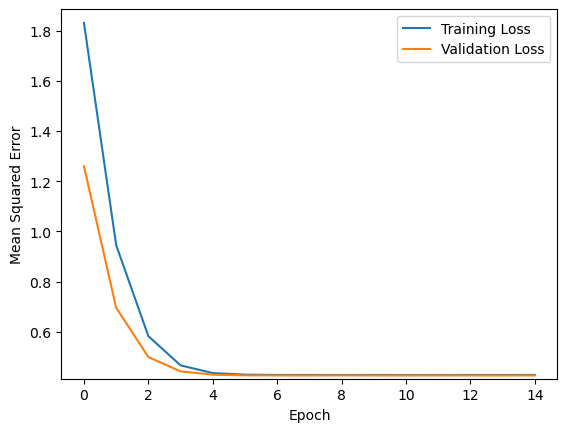


 Evaluate the linear regression model against the test set:
10/10 [==============================] - 0s 2ms/step - loss: 0.4380 - mean_squared_error: 0.4380


{'loss': 0.4380478858947754, 'mean_squared_error': 0.4380478858947754}

In [73]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 15
batch_size = 1000
label_name = "Price"

# Split the original training set into a reduced training set and a
# validation set.
validation_split = 0.2

outputs = get_outputs_linear_regression()

# Establish the model's topography.
my_model = create_model(inputs, outputs, learning_rate)

# Train the model on the normalized training set.
epochs, mse, history = train_model(my_model, train_dataset, epochs, batch_size,
                          label_name, validation_split)
plot_the_loss_curve(epochs, mse, history["val_mean_squared_error"])

test_features = {name:np.array(value) for name, value in test_dataset.items()}
test_label = test_price_normalized(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the linear regression model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size, return_dict=True)

In [74]:
def get_outputs_dnn():
  # Create a Dense layer with 20 nodes.
  dense_output = tf.keras.layers.Dense(units=20,
                              activation='relu',
                              name='hidden_dense_layer_1')(preprocessing_layers)
  # Create a Dense layer with 12 nodes.
  dense_output = tf.keras.layers.Dense(units=12,
                              activation='relu',
                              name='hidden_dense_layer_2')(dense_output)
  # Create the Dense output layer.
  dense_output = tf.keras.layers.Dense(units=1,
                              name='dense_output')(dense_output)

  # Define an output dictionary we'll send to the model constructor.
  outputs = {
    'dense_output': dense_output
  }

  return outputs

Epoch 1/20
32/32 [==============================] - 1s 9ms/step - loss: 0.4870 - mean_squared_error: 0.4870 - val_loss: 0.4367 - val_mean_squared_error: 0.4367
Epoch 2/20
32/32 [==============================] - 0s 4ms/step - loss: 0.4339 - mean_squared_error: 0.4339 - val_loss: 0.4293 - val_mean_squared_error: 0.4293
Epoch 3/20
32/32 [==============================] - 0s 4ms/step - loss: 0.4323 - mean_squared_error: 0.4323 - val_loss: 0.4331 - val_mean_squared_error: 0.4331
Epoch 4/20
32/32 [==============================] - 0s 4ms/step - loss: 0.4312 - mean_squared_error: 0.4312 - val_loss: 0.4299 - val_mean_squared_error: 0.4299
Epoch 5/20
32/32 [==============================] - 0s 3ms/step - loss: 0.4305 - mean_squared_error: 0.4305 - val_loss: 0.4296 - val_mean_squared_error: 0.4296
Epoch 6/20
32/32 [==============================] - 0s 4ms/step - loss: 0.4300 - mean_squared_error: 0.4300 - val_loss: 0.4287 - val_mean_squared_error: 0.4287
Epoch 7/20
32/32 [======================

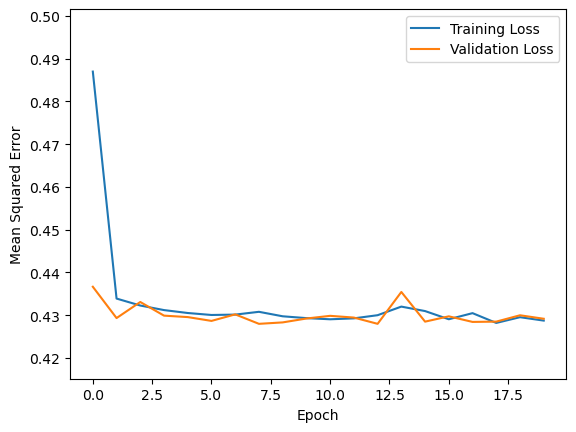


 Evaluate the new model against the test set:
10/10 [==============================] - 0s 2ms/step - loss: 0.4397 - mean_squared_error: 0.4397


{'loss': 0.4396592378616333, 'mean_squared_error': 0.4396592378616333}

In [75]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 20
batch_size = 1000

# Specify the label
label_name = "Price"

# Split the original training set into a reduced training set and a
# validation set.
validation_split = 0.2

dnn_outputs = get_outputs_dnn()

# Establish the model's topography.
my_model = create_model(
    inputs,
    dnn_outputs,
    learning_rate)

# Train the model on the normalized training set. We're passing the entire
# normalized training set, but the model will only use the features
# defined in our inputs.
epochs, mse, history = train_model(my_model, train_dataset, epochs,
                                   batch_size, label_name, validation_split)
plot_the_loss_curve(epochs, mse, history["val_mean_squared_error"])

# After building a model against the training set, test that model
# against the test set.
test_features = {name:np.array(value) for name, value in test_dataset.items()}
test_label = test_price_normalized(np.array(test_features.pop(label_name))) # isolate the label
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size, return_dict=True)

https://developers.google.com/machine-learning/crash-course/introduction-to-neural-networks/programming-exercise?hl=en

https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/intro_to_neural_nets.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=intro_to_nn_tf2-colab&hl=en

https://www.kaggle.com/code/alkidiarete/housing-price-prediction-h2o-ai-automl/notebook

https://www.tensorflow.org/tutorials/keras/regression?hl=pl